In [ ]:
# Project/Cluster Analysis of MicroArray gene data
# Authors: Kopal Rastogi
# Keywords: Clustering, K-means, Centeroid, Spectral Clustering
# Assumptions: None

In [ ]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
print('Importing Libraries ... ', end='')
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statistics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
print('Done')

Importing Libraries ... Done


# **Dataset Preparation**

# Dataset 1: Golub et al.

In [ ]:
# Reading data
print('Reading data ...',end='')
df_train = pd.read_csv('/content/gdrive/MyDrive/Datasets/Golub/data_set_ALL_AML_train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Datasets/Golub/data_set_ALL_AML_independent.csv')
df_label = pd.read_csv('/content/gdrive/MyDrive/Datasets/Golub/actual.csv')
print('Done')

print('Dataset Description')
print('Training data: ',df_train.shape)
print('Test data: ',df_test.shape)
print('Labels: ',df_label.shape)

Reading data ...Done
Dataset Description
Training data:  (7129, 78)
Test data:  (7129, 70)
Labels:  (72, 2)


In [ ]:
print('Training Set Samples ...')
df_train.head()

Training Set Samples ...


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
print('Test Set Samples ...')
df_test.head()

Test Set Samples ...


,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,48,call.4,49,call.5,41,call.6,43,call.7,44,call.8,45,call.9,46,call.10,70,call.11,71,call.12,72,call.13,68,call.14,69,call.15,67,call.16,55,call.17,56,call.18,59,call.19,52,call.20,53,call.21,51,call.22,50,call.23,54,call.24,57,call.25,58,call.26,60,call.27,61,call.28,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,-130,A,-256,A,-62,A,86,A,-146,A,-187,A,-56,A,-55,A,-59,A,-131,A,-154,A,-79,A,-76,A,-34,A,-95,A,-12,A,-21,A,-202,A,-112,A,-118,A,-90,A,-137,A,-157,A,-172,A,-47,A,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,-177,A,-249,A,-23,A,-36,A,-74,A,-187,A,-43,A,-44,A,-114,A,-126,A,-136,A,-118,A,-98,A,-144,A,-118,A,-172,A,-13,A,-274,A,-185,A,-142,A,-87,A,-51,A,-370,A,-122,A,-442,A,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,-28,A,-410,A,-7,A,-141,A,170,A,312,A,43,A,12,A,23,A,-50,A,49,A,-30,A,-153,A,-17,A,59,A,12,A,8,A,59,A,24,A,212,A,102,A,-82,A,-77,A,38,A,-21,A,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,266,A,24,A,142,A,252,A,174,A,142,A,177,A,129,A,146,A,211,A,180,A,68,A,237,A,152,A,270,A,172,A,38,A,309,A,170,A,314,A,319,P,178,A,340,A,31,A,396,A,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,-170,A,-535,A,-233,A,-201,A,-32,A,114,A,-116,A,-108,A,-171,A,-206,A,-257,A,-110,A,-215,A,-174,A,-229,A,-137,A,-128,A,-456,A,-197,A,-401,A,-283,A,-135,A,-438,A,-201,A,-351,A,-256,A,-191,A,-172,A,-496,A,-294,A


In [ ]:
print('Get Labels ...')
print(df_label.head())

Get Labels ...
   patient cancer
0        1    ALL
1        2    ALL
2        3    ALL
3        4    ALL
4        5    ALL


In [ ]:
# Recode label to numeric
df_label = df_label.replace({'ALL':0,'AML':1})

In [ ]:
## We have 7129 Gene descriptions in each row and data for each patient in each column.
## Also, no description for call value is available, so we'll discard them

# Data Cleansing

In [ ]:
# Removing unwanted columns
train_retain = [col for col in df_train.columns if "call" not in col]
test_retain = [col for col in df_test.columns if "call" not in col]
train_retain = df_train[train_retain]
test_retain = df_test[test_retain]

In [ ]:
print(train_retain.shape)
print(test_retain.shape)

(7129, 40)
(7129, 36)


In [ ]:
# Adjusting headers
train_header = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

test_header = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

train_retain = train_retain.reindex(columns=train_header)
test_retain = test_retain.reindex(columns=test_header)

In [ ]:
# Transposing to get each patient record per row
train_X = train_retain.T
test_X = test_retain.T
print(train_X.shape)
train_X.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),AFFX-BioB-M_st (endogenous control),AFFX-BioB-3_st (endogenous control),AFFX-BioC-5_st (endogenous control),AFFX-BioC-3_st (endogenous control),AFFX-BioDn-5_st (endogenous control),AFFX-BioDn-3_st (endogenous control),AFFX-CreX-5_st (endogenous control),AFFX-CreX-3_st (endogenous control),hum_alu_at (miscellaneous control),AFFX-DapX-5_at (endogenous control),AFFX-DapX-M_at (endogenous control),AFFX-DapX-3_at (endogenous control),AFFX-LysX-5_at (endogenous control),AFFX-LysX-M_at (endogenous control),AFFX-LysX-3_at (endogenous control),AFFX-PheX-5_at (endogenous control),AFFX-PheX-M_at (endogenous control),AFFX-PheX-3_at (endogenous control),AFFX-ThrX-5_at (endogenous control),AFFX-ThrX-M_at (endogenous control),AFFX-ThrX-3_at (endogenous control),AFFX-TrpnX-5_at (endogenous control),AFFX-TrpnX-M_at (endogenous control),AFFX-TrpnX-3_at (endogenous control),AFFX-HUMISGF3A/M97935_5_at (endogenous control),AFFX-HUMISGF3A/M97935_MA_at (endogenous control),AFFX-HUMISGF3A/M97935_MB_at (endogenous control),AFFX-HUMISGF3A/M97935_3_at (endogenous control),AFFX-HUMRGE/M10098_5_at (endogenous control),AFFX-HUMRGE/M10098_M_at (endogenous control),...,GB DEF = SPR2-1 gene for small proline rich pr...,Metallothionein,GB DEF = Glutamate dehydrogenase,PRSS3 Protease; serine; 3 (trypsin 3),GB DEF = Transmembrane protein Tmp21-IIex,GB DEF = H2B/h gene,ACTB Actin; beta,GAPD Glyceraldehyde-3-phosphate dehydrogenase,CYTOCHROME P450 IA2,Nkat2b mRNA,Natural killer cell receptor (KIR) mRNA,Major Histocompatibility Complex; Class I; C (...,HLA-A MHC class I protein HLA-A (HLA-A28;-B40;...,PRB2 locus salivary proline-rich protein mRNA;...,HLA CLASS II HISTOCOMPATIBILITY ANTIGEN; DQ(W1...,GB DEF = (HLCC85) mRNA for voltage-dependent L...,GB DEF = Endogenous retrovirus clone P1.8 poly...,Integrase gene extracted from Human endogenous...,WUGSC:GS345D13.2 gene (G-protein gamma-1 subun...,TIAL1 TIA1 cytotoxic granule-associated RNA-bi...,Ras-Specific Guanine Nucleotide-Releasing Factor,TYROSINE-PROTEIN KINASE ITK/TSK,(clone p4) 50 kD dystrophin-associated glycopr...,Ifp35 gene extracted from Human BRCA1; Rho7 an...,INHA Inhibin; alpha,S100A9 S100 calcium-binding protein A9 (calgra...,PLGL Plasminogen-like protein,ID1 Inhibitor of DNA binding 1; dominant negat...,ABP1 Amiloride binding protein 1 (amine oxidas...,Transcriptional activator hSNF2b,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-

In [ ]:
# Removing duplicates
train_X.columns = train_X.iloc[1]
train_X = train_X.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

test_X.columns = test_X.iloc[1]
test_X = test_X.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(train_X.shape)
print(test_X.shape)
train_X.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25


In [ ]:
#concatenating dataframes
data1 = pd.concat([train_X, test_X])

In [ ]:
data1

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-154,-136,49,180,-257,-273,141,-123,52,878,-51,-592,-219,-149,-76,391,-11,-190,19457,105,241,-4,43,-44,171,5,-99,-14,80,-49,-138,51,-490,-101,-117,-1122,185,694,32,-104,...,188,-798,619,115,343,866,19394,16120,621,244,52,12712,9978,-27,2758,-161,172,206,67,215,35,40,-111,206,60,165,135,30,-444,1088,214,540,13,1075,-45,524,249,40,-68,-1
69,-79,-118,-30,68,-110,-264,-28,-61,40,-217,-52,-247,-454,-11,187,154,0,-322,17499,-5,135,-170,11,-144,123,-101,-154,44,6,-37,-265,112,-313,-181,-22,607,582,1512,53,-49,...,217,-255,420,375,563,501,18295,13564,554,164,113,12952,13480,365,1451,-105,57,242,20,174,57,453,65,291,11,143,251,-75,97,1187,409,617,-34,738,11,742,234,72,109,-30
70,-55,-44,12,129,-108,-301,-222,-133,136,320,81,-518,-168,-102,57,105,-61,-167,2990

In [ ]:
# Get dataset description
train_X.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,67.947368,-701.105263,-492.868421,-194.394737,110.263158,189.894737,-70.868421,-342.105263,20276.657895,29.210526,170.315789,-95.421053,19.131579,-151.763158,89.631579,-91.631579,-134.157895,-7.368421,-21.184211,-48.447368,-278.342105,7.184211,-550.710526,-245.447368,-206.921053,-2.026316,214.236842,765.263158,4133.368421,2576.315789,...,268.815789,-365.921053,271.210526,483.078947,396.631579,463.342105,17991.447368,16025.789474,819.473684,292.868421,171.894737,10554.526316,9033.710526,396.921053,2495.921053,-230.894737,10.763158,319.105263,-9.105263,222.815789,53.421053,73.368421,-21.368421,266.789474,128.842105,220.105263,334.605263,-273.684211,-1678.842105,965.263158,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,168.362535,235.446647,219.930231,124.907001,136.108995,132.304683,70.325179,193.686957,7546.053808,81.206829,101.666946,60.176152,38.604839,108.490237,80.849684,45.844285,57.983468,65.672990,51.336124,38.629003,115.244576,54.755405,156.187155,68.982841,135.338890,439.362037,315.278636,737.537381,5690.572471,4141.001342,...,99.401413,657.032369,228.186168,1462.672459,161.848515,469.653022,5782.493541,3883.585841,530.540303,159.607317,248.903410,3581.291657,3982.630931,321.125502,1986.098340,95.769653,66.839636,188.752775,52.387222,111.896394,46.237712,62.082082,201.001737,128.158719,124.958485,92.496542,172.760503,166.168281,929.175064,754.069489,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,-209.000000,-1250.000000,-962.000000,-541.000000,-96.000000,-156.000000,-179.000000,-874.000000,6479.000000,-126.000000,-39.0

In [ ]:
data1 = data1.astype(float,64)
scaler = StandardScaler()
data1 = scaler.fit_transform(data1)

# Pickle and Un-pickle

In [ ]:
pkl.dump(data1, open('/content/gdrive/MyDrive/Datasets/Golub/data.pkl','wb'))
pkl.dump(df_label,open('/content/gdrive/MyDrive/Datasets/Golub/label.pkl','wb'))

In [ ]:
# Retrieve pre-processed data
data1 = pkl.load(open('/content/gdrive/MyDrive/Datasets/Golub/data.pkl','rb'))
label1 = pkl.load(open('/content/gdrive/MyDrive/Datasets/Golub/label.pkl','rb'))
data1.shape, label1.shape

((72, 7129), (72, 2))

In [ ]:
label1

,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
67,68,0
68,69,0
69,70,0
70,71,0


# **Dimensionality Reduction and Visualization**

In [ ]:
def get_PCA(data):
  pca =PCA()
  pca.fit_transform(data)

  total = sum(pca.explained_variance_)
  k = 0
  current_variance = 0
  while current_variance/total < 0.90:
      current_variance += pca.explained_variance_[k]
      k = k + 1
    
  print(k,'features explain around 90% of the variance. From', data.shape[1], 'features to ',k)

  pca = PCA(n_components=k)
  data_pca = pca.fit(data)
  data_pca = pca.transform(data)
  
  var_exp = pca.explained_variance_ratio_.cumsum()
  var_exp = var_exp*100
  plt.bar(range(k), var_exp)

  return data_pca


51 features explain around 90% of the variance. From 7129 features to  51


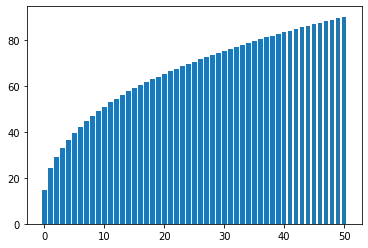

In [ ]:
data_pca1 = get_PCA(data1)

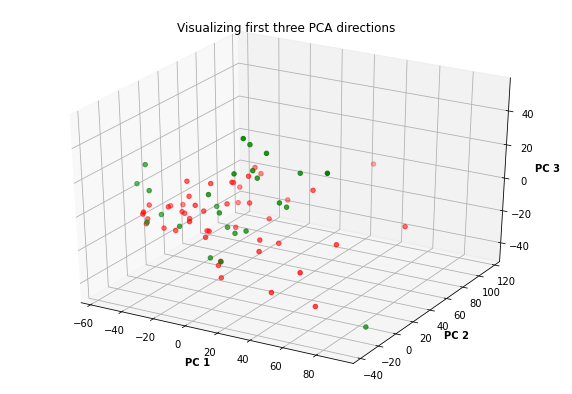

In [ ]:
# Plot Data
colors = {0:'red', 1:'green'}
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(data_pca1[:,0],data_pca1[:,1],data_pca1[:,2],c=(pd.Series(label1['cancer'])).map(colors))
plt.title("Visualizing first three PCA directions")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')
plt.show()

In [ ]:
data_pca1

array([[ 27.10520637,   6.44848167, -14.95683551, ...,   6.96465591,
         -3.76972332,   5.02319063],
       [  3.50741937,  15.84579242,  17.27282726, ...,  -0.11750932,
          7.21588121,  -6.04291207],
       [ 60.00637856,  10.39230551, -10.55485844, ...,   2.10342764,
          0.25708642,  -3.65001173],
       ...,
       [-43.35057116, -17.03104999,  -3.64693646, ...,  -2.20939783,
         -1.35448508,  -6.13618862],
       [-24.01982653,  -0.50898679,   5.34932323, ...,   0.3041907 ,
          3.74444083,   2.54209568],
       [ -7.06924511,  10.65164154,   0.51248625, ...,   1.19256129,
          6.46827751,   6.09540178]])

In [ ]:
# Save the PCA components
pkl.dump(data_pca1, open('/content/gdrive/MyDrive/Datasets/Golub/data_pca.pkl','wb'))

In [ ]:
# Retrieve the PCA components
data_pca1 = pkl.load(open('/content/gdrive/MyDrive/Datasets/Golub/data_pca.pkl','rb'))

# **Dataset 2: CAMIDA**

In [ ]:
# Reading data
data2 = pd.read_csv('/content/gdrive/MyDrive/Datasets/Camida/Breast_GSE45827.csv',index_col=0)

In [ ]:
data2.shape

(151, 54676)

In [ ]:
data2.head()

,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552258_at,1552261_at,1552263_at,1552264_a_at,1552266_at,1552269_at,1552271_at,1552272_a_at,1552274_at,1552275_s_at,1552276_a_at,1552277_a_at,1552278_a_at,1552279_a_at,1552280_at,1552281_at,1552283_s_at,1552286_at,1552287_s_at,1552288_at,1552289_a_at,1552291_at,1552293_at,1552295_a_at,...,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
samples,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,8.870780,3.278896,7.317273,6.941792,4.753893,9.689422,9.529578,4.416768,4.061347,6.468291,8.671009,3.766666,3.711459,5.076329,4.442042,6.741298,5.627442,5.516712,8.107136,4.956239,5.791279,3.569233,5.687476,4.152096,4.906925,8.206707,4.463950,5.186044,5.942088,4.191142,7.413500,...,9.015007,12.050521,14.750905,13.359472,5.576968,3.606041,4.481027,5.509117,10.544533,11.200692,5.932332,4.253946,5.052679,7.782348,7.056759,7.787824,4.784976,3.943038,3.903069,6.119248,4.461984,4.752744,6.761262,5.298281,6.048960,8.292124,8.225293,8.333853,9.854639,9.823275,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,7.767646,3.589636,8.768129,7.567034,4.859823,8.459354,8.973671,4.503730,5.390424,6.756707,8.105795,4.651541,3.935309,5.228763,4.454780,6.468014,5.798596,5.306064,7.505800,4.636866,5.898319,3.749061,5.582313,4.449042,5.871074,7.242601,3.938327,4.378953,6.294126,4.058221,6.799876,...,9.371174,8.264719,9.938357,9.507651,6.103962,3.983087,4.742306,5.424172,8.881772,11.148811,6.330691,4.755615,5.474167,8.542725,7.617779,8.237535,5.209694,3.939264,4.553344,6.017351,5.425393,4.957182,7.405313,5.615380,6.617585,8.225366,8.409790,8.499343,10.061910,9.796947,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,9.417956,3.552253,7.945085,7.238284,4.872635,9.367521,9.133688,4.358608,4.445164,5.476936,8.752115,3.546838,4.263868,5.509159,4.624205,7.103216,6.641263,5.141131,7.072525,4.728196,6.233648,3.766725,6.008163,4.191390,5.717077,7.809222,4.108028,5.012451,7.258626,4.330997,6.901454,...,8.842430,10.241912,13.605901,11.784269,5.853014,3.748889,4.407490,5.919699,9.687444,11.601339,6.040000,4.314678,5.274790,8.030696,7.082369,7.912491,4.725483,4.036020,4.141341,5.825904,5.032693,4.764559,7.026349,5.448507,6.386042,8.218749,8.209361,8.280136,9.699647,9.452066,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,9.022345,3.312473,7.754670,7.078843,4.867320,7.790225,7.206228,4.680283,4.171577,5.985232,7.205984,3.568459,3.310109,5.166409,4.160049,6.730255,5.774961,6.092539,7.164589,4.903609,5.726683,3.532517,5.652934,3.997426,6.151148,7.189197,4.329053,5.134634,6.300199,4.192591,7.082357,...,10.554449,9.191622,12.146083,11.018158,5.972863,3.658838,4.657377,5.508931,9.262102,11.338670,6.194179,4.300024,5.072087,8.148625,7.548858,7.960282,5.22

In [ ]:
label2 = data2['type']
data2 = data2.iloc[:,1:]

In [ ]:
# Recode label to numeric
label2 = label2.replace({'basal':0,'HER':1, 'cell_line':2, 'normal':3, 'luminal_A':4, 'luminal_B':5})

In [ ]:
# Data Standardization
data2 = data2.astype(float,64)
scaler = StandardScaler()
data2 = scaler.fit_transform(data2)

In [ ]:
# Save the pre-processed data
print('Storing data ... ', end='')
pkl.dump(data2, open('/content/gdrive/MyDrive/Datasets/Camida/data.pkl','wb'))
pkl.dump(label2,open('/content/gdrive/MyDrive/Datasets/Camida/label.pkl','wb'))
print('Done')

Storing data ... Done


In [ ]:
# Load Data
print('Loading data ... ',end='')
data2 = pkl.load(open('/content/gdrive/MyDrive/Datasets/Camida/data.pkl','rb'))
label2 = pkl.load(open('/content/gdrive/MyDrive/Datasets/Camida/label.pkl','rb'))
print('Done')

Loading data ... Done


106 features explain around 90% of the variance. From 54675 features to  106


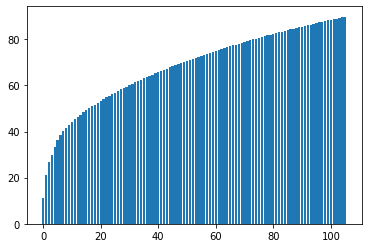

In [ ]:
data_pca2= get_PCA(data2)

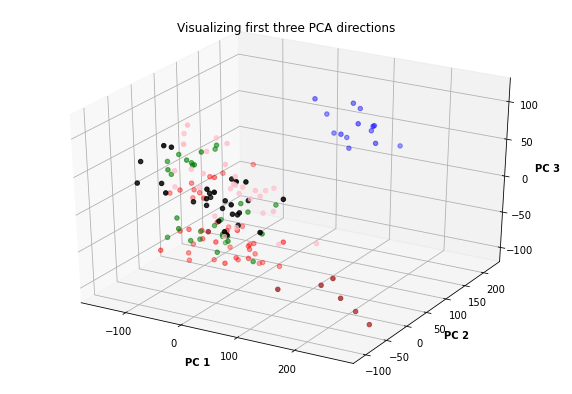

In [ ]:
# Plot Data
colors = {0:'red', 1:'green', 2:'blue', 3:'brown', 4:'black', 5:'pink'}
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(data_pca2[:,0],data_pca2[:,1],data_pca2[:,2],c=(pd.Series(label2)).map(colors))
plt.title("Visualizing first three PCA directions")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')
plt.show()

In [ ]:
# Save the PCA components
pkl.dump(data_pca2, open('/content/gdrive/MyDrive/Datasets/Camida/data_pca.pkl','wb'))

In [ ]:
# Retrieve the PCA components
data_pca2 = pkl.load(open('/content/gdrive/MyDrive/Datasets/Camida/data_pca.pkl','rb'))

In [ ]:
def plot_data(name, labels, clustering):
  if name == 'Golub':
    colors = {0:'red', 1:'green'}
    data = pkl.load(open('/content/gdrive/MyDrive/Datasets/Golub/data_pca.pkl','rb'))
  elif name == 'Camida':
    colors = {0:'red', 1:'green', 2:'blue', 3:'brown', 4:'black', 5:'pink'}
    data = pkl.load(open('/content/gdrive/MyDrive/Datasets/Camida/data_pca.pkl','rb'))

  plt.scatter(data[:,0],data[:,1],c=(pd.Series(labels)).map(colors))
  del data
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.title(name+':'+clustering)
  plt.savefig('/content/gdrive/MyDrive/Figures/'+name+'_'+clustering+'.png')
  plt.show()

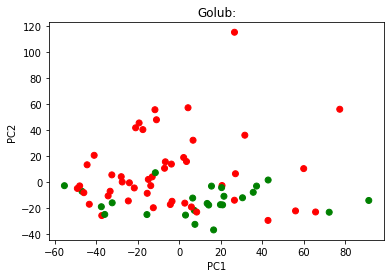

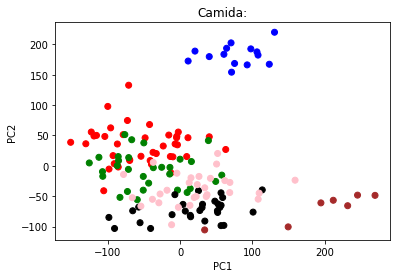

In [ ]:
plot_data(name='Golub',labels=label1['cancer'],clustering='')
plot_data(name='Camida',labels=label2,clustering='')

# **Model Building**

1. K-means
2. DBSCAN 
3. Agglomerative Clustering
4. Spectral Clustering
5. Self-Organizing Map





# **K-means**

**Without PCA**

In [ ]:
def kmeans_clustering(data, label, name):
  if name == 'Golub':
    k = 2
  elif name == 'Camida':
    k = 6
  nmi_scores = []
  ari_scores = []
  for i in range(10):
    model = KMeans(n_clusters=k,init='random', random_state=None)
    result =  model.fit_predict(data)
    nmi_scores.append(normalized_mutual_info_score(labels_true=(np.array(label)), labels_pred=result))
    ari_scores.append(adjusted_rand_score(labels_true=(np.array(label)), labels_pred=result))
  return result, nmi_scores, ari_scores

In [ ]:
pred1, nmi_scores1, ari_scores1 = kmeans_clustering(data1,label1['cancer'], name='Golub')
pred2, nmi_scores2, ari_scores2 = kmeans_clustering(data2, label2, name='Camida')

In [ ]:
print('For Dataset 1')
print('Average NMI:', sum(nmi_scores1)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores1))
print('Average ARI:', sum(ari_scores1)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores1))
print('='*55)
print('For Dataset 2')
print('Average NMI:', sum(nmi_scores2)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores2))
print('Average ARI:', sum(ari_scores2)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores2))

For Dataset 1
Average NMI: 0.16440402429571152
It varies by +/-: 0.026673379996297358
Average ARI: 0.22858454838495904
It varies by =/-: 0.043181923408725495
For Dataset 2
Average NMI: 0.6034412365016281
It varies by +/-: 0.01596324122870318
Average ARI: 0.4031734789821602
It varies by =/-: 0.017331141095707846


# **Visualizing Clusters**


In [ ]:
# def plot_data(name, labels, clustering):
#   if name == 'Golub':
#     colors = {0:'red', 1:'green'}
#     data = pkl.load(open('/content/gdrive/MyDrive/Datasets/Golub/data_pca.pkl','rb'))
#   elif name == 'Camida':
#     colors = {0:'red', 1:'green', 2:'blue', 3:'brown', 4:'black', 5:'pink'}
#     data = pkl.load(open('/content/gdrive/MyDrive/Datasets/Camida/data_pca.pkl','rb'))

#   plt.scatter(data[:,0],data[:,1],c=(pd.Series(labels)).map(colors))
#   del data
#   plt.xlabel('PC1')
#   plt.ylabel('PC2')
#   plt.title(name+':'+clustering)
#   plt.savefig('/content/gdrive/MyDrive/Figures/'+name+'_'+clustering+'.png')
#   plt.show()

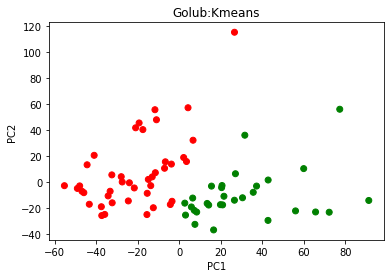

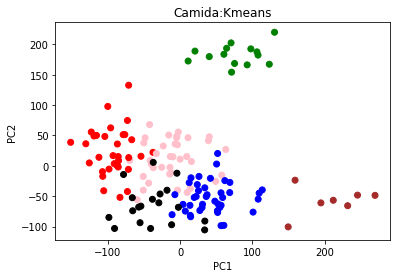

In [ ]:
plot_data('Golub',pred1,'Kmeans')
plot_data('Camida',pred2,'Kmeans')

**Kmeans with PCA**

In [ ]:
pred1p, nmi_scores1p, ari_scores1p = kmeans_clustering(data_pca1, label1['cancer'], name='Golub')
pred2p, nmi_scores2p, ari_scores2p = kmeans_clustering(data_pca2, label2, name='Camida')

In [ ]:
print('For Dataset 1')
print('Average NMI:', sum(nmi_scores1p)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores1p))
print('Average ARI:', sum(ari_scores1p)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores1p))
print('='*55)
print('For Dataset 2')
print('Average NMI:', sum(nmi_scores2p)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores2p))
print('Average ARI:', sum(ari_scores2p)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores2p))

For Dataset 1
Average NMI: 0.13836115130826565
It varies by +/-: 0.035288820111544945
Average ARI: 0.1887437889303913
It varies by =/-: 0.05577100625168341
For Dataset 2
Average NMI: 0.6151006035237879
It varies by +/-: 0.02794063499245653
Average ARI: 0.41474920931367976
It varies by =/-: 0.03484280755633379


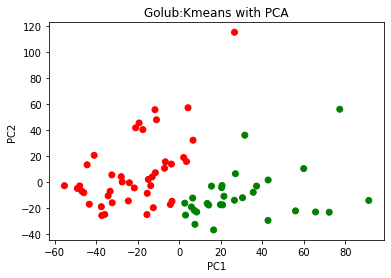

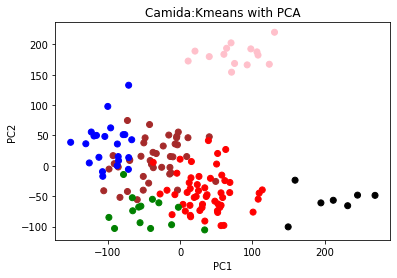

In [ ]:
plot_data('Golub',pred1p,'Kmeans with PCA')
plot_data('Camida',pred2p,'Kmeans with PCA')

# **DBSCAN**

**Without PCA**

In [ ]:
def get_DBSCAN(data, label, name):
  if name == 'Golub':
    eps = 80
    min_samples=7
  elif name == 'Camida':
    eps = 250
    min_samples=5
  model = DBSCAN(eps=eps,min_samples=min_samples).fit(data)
  result =  model.labels_
  nmi_scores = normalized_mutual_info_score(labels_true=(np.array(label)), labels_pred=result)
  ari_scores = adjusted_rand_score(labels_true=(np.array(label)), labels_pred=result)
  return result, nmi_scores, ari_scores

In [ ]:
pred1, nmi_scores1, ari_scores1 = get_DBSCAN(data1, label1['cancer'], name='Golub')
pred2, nmi_scores2, ari_scores2 = get_DBSCAN(data2, label2, name='Camida')

In [ ]:
print('For Dataset 1')
print('NMI:', nmi_scores1)
print('ARI:', ari_scores1)
print('='*55)
print('For Dataset 2')
print('NMI:', nmi_scores2)
print('ARI:', ari_scores2)

For Dataset 1
NMI: 0.04386004433947303
ARI: -0.04398196918410936
For Dataset 2
NMI: 0.21715228436354173
ARI: 0.1311794792500894


In [ ]:
pred1 = np.where(pred1 == -1, 1, pred1)
pred2 = np.where(pred2 == -1, 1, pred2)

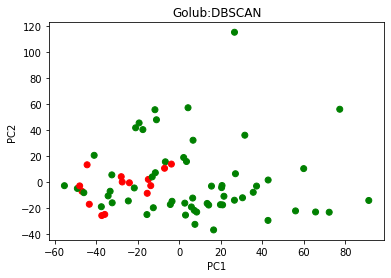

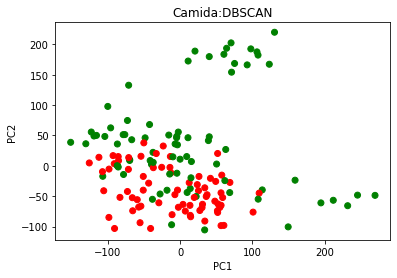

In [ ]:
plot_data('Golub',pred1,'DBSCAN')
plot_data('Camida',pred2,'DBSCAN')

**With PCA**

In [ ]:
pred1p, nmi_scores1p, ari_scores1p = get_DBSCAN(data_pca1, label1['cancer'], name='Golub')
pred2p, nmi_scores2p, ari_scores2p = get_DBSCAN(data_pca2, label2, name='Camida')

In [ ]:
print('For Dataset 1')
print('NMI:', nmi_scores1p)
print('ARI:', ari_scores1p)
print('='*55)
print('For Dataset 2')
print('NMI:', nmi_scores2p)
print('ARI:', ari_scores2p)

For Dataset 1
NMI: 0.08262814619891783
ARI: 0.11715121090086611
For Dataset 2
NMI: 0.22841062824739852
ARI: 0.08308047213038754


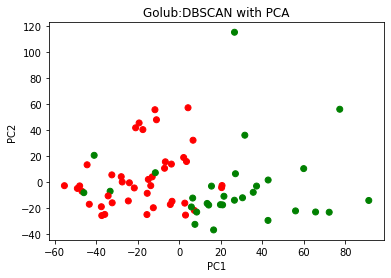

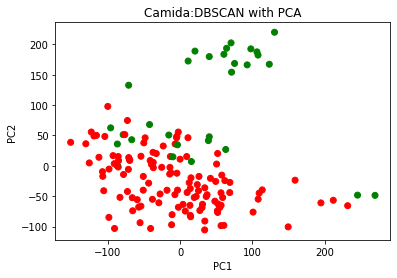

In [ ]:
pred1p = np.where(pred1p == -1, 1, pred1p)
pred2p = np.where(pred2p == -1, 1, pred2p)
plot_data('Golub',pred1p,'DBSCAN with PCA')
plot_data('Camida',pred2p,'DBSCAN with PCA')

### **Spectral Clustering**

**Without PCA**

In [ ]:
def get_spectral(data,label,name):
  if name == 'Golub':
    k = 2
  elif name == 'Camida':
    k = 6
  nmi_scores = []
  ari_scores = []
  for i in range(10):
    model = SpectralClustering(n_clusters=k, assign_labels='kmeans',random_state=None,affinity='nearest_neighbors').fit(data)
    result = model.labels_
    nmi_scores.append(normalized_mutual_info_score(labels_true=(np.array(label)), labels_pred=result))
    ari_scores.append(adjusted_rand_score(labels_true=(np.array(label)), labels_pred=result))
  return result, nmi_scores, ari_scores

In [ ]:
pred1, nmi_scores1, ari_scores1 = get_spectral(data1,label1['cancer'], name='Golub')
pred2, nmi_scores2, ari_scores2 = get_spectral(data2,label2,name='Camida')

In [ ]:
print('For Dataset 1')
print('Average NMI:', sum(nmi_scores1)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores1))
print('Average ARI:', sum(ari_scores1)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores1))
print('='*55)
print('For Dataset 2')
print('Average NMI:', sum(nmi_scores2)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores2))
print('Average ARI:', sum(ari_scores2)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores2))

For Dataset 1
Average NMI: 0.10266934243510936
It varies by +/-: 0.0
Average ARI: 0.13889999957122634
It varies by =/-: 0.0
For Dataset 2
Average NMI: 0.6370247706786872
It varies by +/-: 1.4802973661668753e-16
Average ARI: 0.47419843692008345
It varies by =/-: 0.0


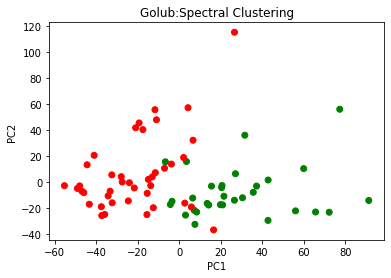

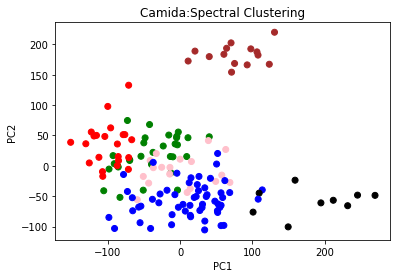

In [ ]:
plot_data('Golub',pred1,'Spectral Clustering')
plot_data('Camida',pred2,'Spectral Clustering')

**With PCA**

In [ ]:
pred1p, nmi_scores1p, ari_scores1p = get_spectral(data_pca1,label1['cancer'], name='Golub')
pred2p, nmi_scores2p, ari_scores2p = get_spectral(data_pca2,label2,name='Camida')

In [ ]:
print('For Dataset 1')
print('Average NMI:', sum(nmi_scores1p)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores1p))
print('Average ARI:', sum(ari_scores1p)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores1p))
print('='*55)
print('For Dataset 2')
print('Average NMI:', sum(nmi_scores2p)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores2p))
print('Average ARI:', sum(ari_scores2p)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores2p))

For Dataset 1
Average NMI: 0.10734230161140904
It varies by +/-: 0.0
Average ARI: 0.15953371903526212
It varies by =/-: 0.0
For Dataset 2
Average NMI: 0.5607360125717534
It varies by +/-: 5.851389114294502e-17
Average ARI: 0.3592445644432944
It varies by =/-: 0.0


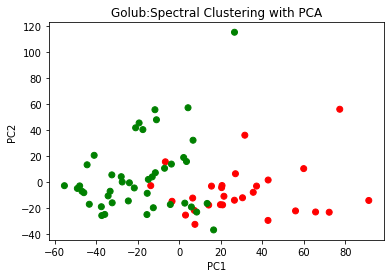

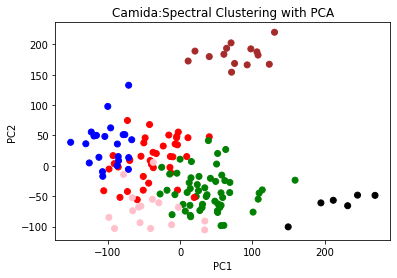

In [ ]:
plot_data('Golub',pred1p,'Spectral Clustering with PCA')
plot_data('Camida',pred2p,'Spectral Clustering with PCA')

# **Agglomerative Clustering**

**Without PCA**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
def get_Agglomerative(data, label, name):
  if name == 'Golub':
    k = 2
  elif name == 'Camida':
    k = 6
  model = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average').fit(data)
  result =  model.labels_
  nmi_scores = normalized_mutual_info_score(labels_true=(np.array(label)), labels_pred=result)
  ari_scores = adjusted_rand_score(labels_true=(np.array(label)), labels_pred=result)
  return result, nmi_scores, ari_scores

In [ ]:
pred1, nmi_scores1, ari_scores1 = get_Agglomerative(data1,label1['cancer'], name='Golub')
pred2, nmi_scores2, ari_scores2 = get_Agglomerative(data2,label2,name='Camida')

In [ ]:
print('For Dataset 1')
print('NMI:', nmi_scores1)
print('ARI:', ari_scores1)
print('='*55)
print('For Dataset 2')
print('NMI:', nmi_scores2)
print('ARI:', ari_scores2)

For Dataset 1
NMI: 0.15466970475938052
ARI: 0.2111546312131075
For Dataset 2
NMI: 0.5971368043318261
ARI: 0.3952446863825572


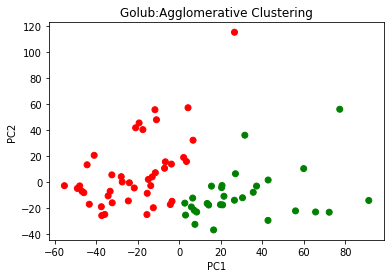

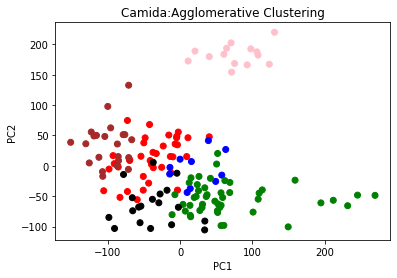

In [ ]:
plot_data('Golub',pred1,'Agglomerative Clustering')
plot_data('Camida',pred2,'Agglomerative Clustering')

**With PCA**

In [ ]:
pred1p, nmi_scores1p, ari_scores1p = get_Agglomerative(data_pca1,label1['cancer'], name='Golub')
pred2p, nmi_scores2p, ari_scores2p = get_Agglomerative(data_pca2,label2,name='Camida')

In [ ]:
print('For Dataset 1')
print('NMI:', nmi_scores1p)
print('ARI:', ari_scores1p)
print('='*55)
print('For Dataset 2')
print('NMI:', nmi_scores2p)
print('ARI:', ari_scores2p)

For Dataset 1
NMI: 0.1894811513588283
ARI: 0.26625959598316534
For Dataset 2
NMI: 0.5938431746140467
ARI: 0.38975821323753845


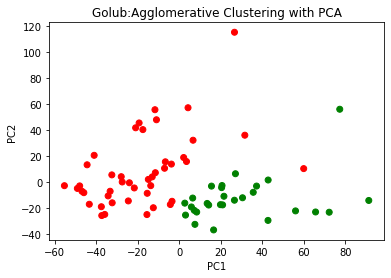

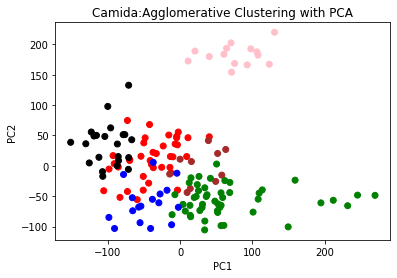

In [ ]:
plot_data('Golub',pred1p,'Agglomerative Clustering with PCA')
plot_data('Camida',pred2p,'Agglomerative Clustering with PCA')

# **Self-Organizing Map**

In [ ]:
!pip install sklearn-som

**Without PCA**

In [ ]:
from sklearn_som.som import SOM
def get_SOM(data,label,name):
  if name == 'Golub':
    m = 1
    n = 2
  elif name == 'Camida':
    m = 1
    n = 6
  nmi_scores = []
  ari_scores = []  
  for i in range(10):
    model = SOM(m=m, n=n, dim=data.shape[1])
    model.fit(data)
    result = model.predict(data)
    nmi_scores.append(normalized_mutual_info_score(labels_true=(np.array(label)), labels_pred=result))
    ari_scores.append(adjusted_rand_score(labels_true=(np.array(label)), labels_pred=result))
  return result, nmi_scores, ari_scores

In [ ]:
pred1, nmi_scores1, ari_scores1 = get_SOM(data1,label1['cancer'], name='Golub')
pred2, nmi_scores2, ari_scores2 = get_SOM(data2,label2,name='Camida')

In [ ]:
print('For Dataset 1')
print('Average NMI:', sum(nmi_scores1)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores1))
print('Average ARI:', sum(ari_scores1)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores1))
print('='*55)
print('For Dataset 2')
print('Average NMI:', sum(nmi_scores2)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores2))
print('Average ARI:', sum(ari_scores2)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores2))

For Dataset 1
Average NMI: 0.0892283674831948
It varies by +/-: 0.05909878710261092
Average ARI: 0.12198672169455996
It varies by =/-: 0.0856065456171873
For Dataset 2
Average NMI: 0.5442138990982199
It varies by +/-: 0.06813617771464416
Average ARI: 0.3685868815686235
It varies by =/-: 0.11585745238309383


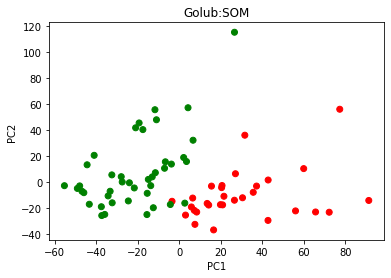

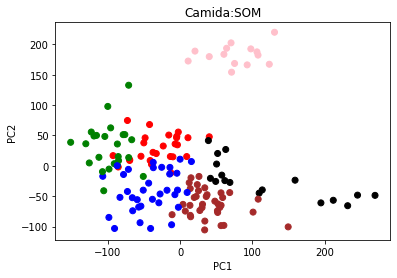

In [ ]:
plot_data('Golub',pred1,'SOM')
plot_data('Camida',pred2,'SOM')

**With PCA**

In [ ]:
pred1p, nmi_scores1p, ari_scores1p = get_SOM(data_pca1,label1['cancer'], name='Golub')
pred2p, nmi_scores2p, ari_scores2p = get_SOM(data_pca2,label2,name='Camida')

In [ ]:
print('For Dataset 1')
print('Average NMI:', sum(nmi_scores1p)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores1p))
print('Average ARI:', sum(ari_scores1p)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores1p))
print('='*55)
print('For Dataset 2')
print('Average NMI:', sum(nmi_scores2p)/10.0)
print('It varies by +/-:',statistics.stdev(nmi_scores2p))
print('Average ARI:', sum(ari_scores2p)/10.0)
print('It varies by =/-:',statistics.stdev(ari_scores2p))

For Dataset 1
Average NMI: 0.12004409900421742
It varies by +/-: 0.04963921102719902
Average ARI: 0.15779260250762323
It varies by =/-: 0.06786532082027376
For Dataset 2
Average NMI: 0.5139323262299841
It varies by +/-: 0.045335977290502136
Average ARI: 0.3222496681850887
It varies by =/-: 0.06173952154818922


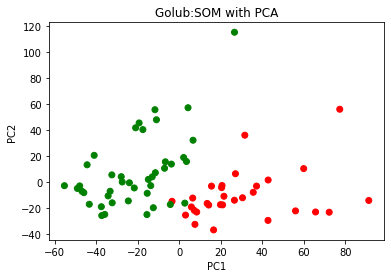

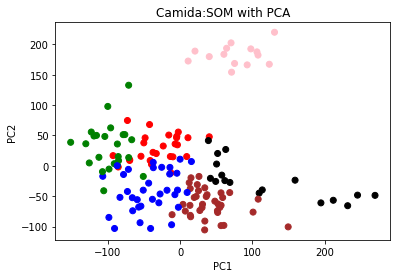

In [ ]:
plot_data('Golub',pred1,'SOM with PCA')
plot_data('Camida',pred2,'SOM with PCA')